# Optimizing workflows
In this notebook we demonstrate how to setup a workflow and optimize its parameters with a given sparse annotation.

See also:
* [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
* [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [1]:
from skimage.io import imread
from scipy.optimize import minimize
import numpy as np
import pyclesperanto as cle

We start with loading an example image and a manual annotation. Not all objects must be annotated (sparse annotation).

array([[ 40.,  32.,  24., ..., 216., 200., 200.],
       [ 56.,  40.,  24., ..., 232., 216., 216.],
       [ 64.,  48.,  24., ..., 240., 232., 232.],
       ...,
       [ 72.,  80.,  80., ...,  48.,  48.,  48.],
       [ 80.,  80.,  80., ...,  48.,  48.,  48.],
       [ 96.,  88.,  80., ...,  48.,  48.,  48.]], dtype=float32, mtype=buffer)
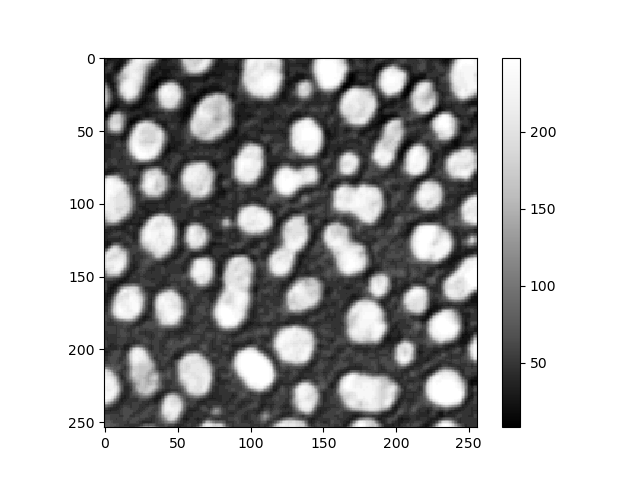
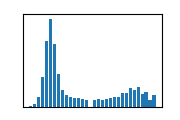

In [2]:
blobs = cle.push(imread('https://samples.fiji.sc/blobs.png').squeeze().astype(float))
blobs

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32, mtype=buffer)
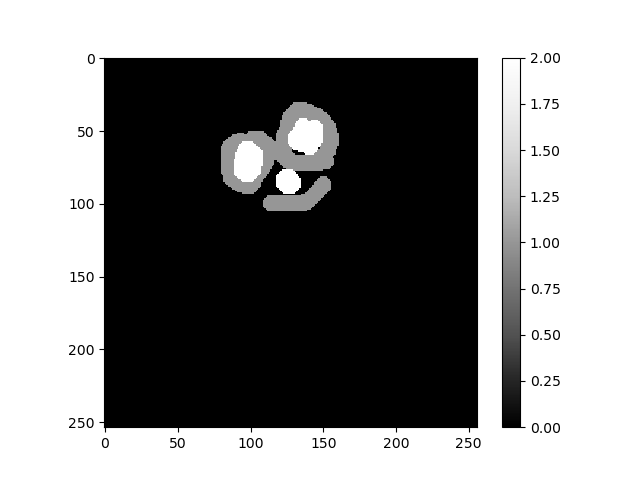
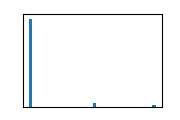

In [4]:
annotation = cle.push(imread('https://github.com/clEsperanto/pyclesperanto_prototype/raw/master/data/blobs_annotated.tif'))
annotation

Next, we define an image processing workflow that results in a binary image.

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8, mtype=buffer)
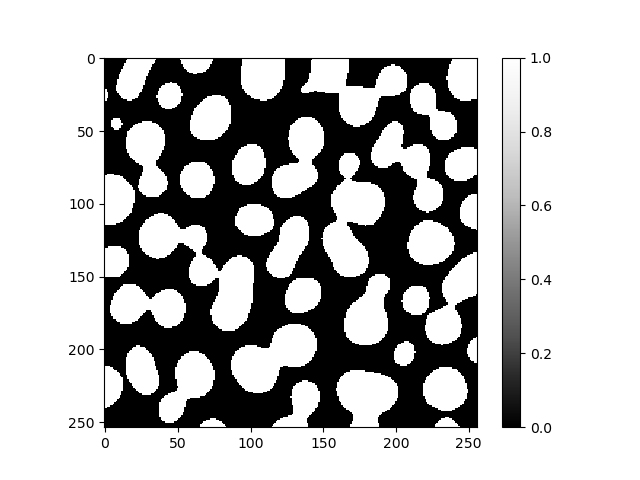
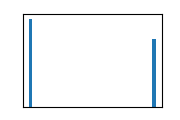

In [6]:
def workflow(image, sigma, threshold):
    blurred = cle.gaussian_blur(image, sigma_x=sigma, sigma_y=sigma)
    binary = cle.greater_constant(blurred, scalar=threshold)
    return binary
  
# Test the workflow with more or less random parameters
test = workflow(blobs, 5, 100)
test

Our [fitness function](https://en.wikipedia.org/wiki/Fitness_function) takes two parameters: A given segmentation result (test) and a reference annotation. It then determines how good the segmentation is, e.g. using the Jaccard index.

In [7]:
binary_and = cle.binary_and

def fitness(test, reference):
    """
    Determine how correct a given test segmentation is. 
    As metric we use the Jaccard index.
    Assumtion: test is a binary image(0=False and 1=True) and 
    reference is an image with 0=unknown, 1=False, 2=True.
    """
    negative_reference = reference == 1
    positive_reference = reference == 2
    negative_test = test == 0
    positive_test = test == 1
    
    # true positive: test = 1, ref = 2
    tp = binary_and(positive_reference, positive_test).sum()
    
    # true negative: 
    tn = binary_and(negative_reference, negative_test).sum()
    
    # false positive
    fp = binary_and(negative_reference, positive_test).sum()

    # false negative
    fn = binary_and(positive_reference, negative_test).sum()
    
    # return Jaccard Index
    return tp / (tp + fn + fp)

fitness(test, annotation)

0.7425149700598802

In [8]:
# test a couple of thresholds and print corresponding fitness
for t in range(70, 180, 10):
    test = workflow(blobs, 5, t)
    print(fitness(test, annotation))

0.4904862579281184
0.5843037974683545
0.6701940035273368
0.7425149700598802
0.8183873398643556
0.8378158109209454
0.790893760539629
0.7024013722126929
0.6060344827586207
0.4982758620689655
0.39741379310344827


The `fun`ction takes only numerical parameters that should be optimized.

Optimization terminated successfully.
         Current function value: -0.857613
         Iterations: 22
         Function evaluations: 65
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.8576131687242798
             x: [ 3.895e+00  1.219e+02]
           nit: 22
          nfev: 65
 final_simplex: (array([[ 3.895e+00,  1.219e+02],
                       [ 3.895e+00,  1.219e+02],
                       [ 3.895e+00,  1.219e+02]]), array([-8.576e-01, -8.576e-01, -8.576e-01]))


array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8, mtype=buffer)
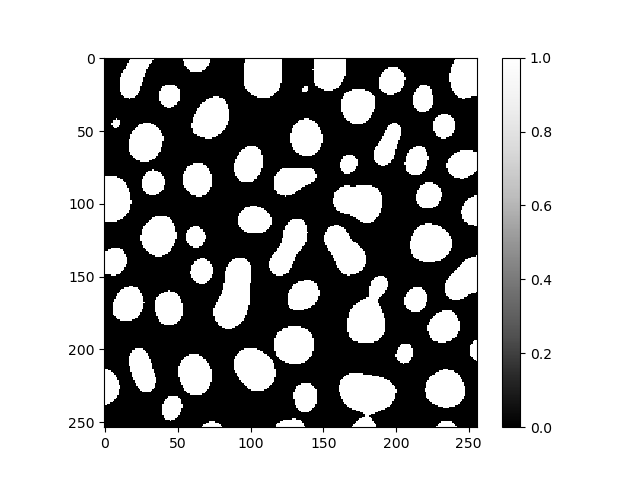
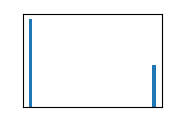

In [10]:
def fun(x):
    # apply current parameter setting
    test = workflow(blobs, x[0], x[1])
    # as we are minimizing, we multiply fitness with -1
    return -fitness(test, annotation)

# starting point in parameter space
x0 = np.array([5, 100])

# run the optimization
res = minimize(fun, x0, method='nelder-mead', options={'xatol': 1e-3, 'disp': True})

# print and show result
print(res)

x = res['x']
best_binary = workflow(blobs, x[0], x[1])
best_binary